Make the maps: (1) sampling area outlines with pharmacies, (2) pie chart of relative MME, (3) small multiples of detection frequency.

In [1]:
import pandas as pd
import geopandas as gpd

import numpy as np
import math

import contextily as ctx

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

# Read in data

Data has been pre-processed elsewhere to preserve anonymity.

In [2]:
fdata = '../data/tidy_2018_data.csv'
fcity = '../data/anonymized_city_Jan2020.shp'
fpharma = '../data/pharmacies.shp'

data = pd.read_csv(fdata)
city = gpd.read_file(fcity)
pharm = gpd.read_file(fpharma)

city = city.rename(columns={'Catchment_': 'Catchment_ID'})

# Get right projection for contextily basemap
city.crs = {'init': 'epsg:3857'}
pharm.crs = {'init': 'epsg:3857'}

In [3]:
data.head()

,Report_ID,Catchment_ID,Parent_drug,MME_rate(MME/day/1000people),Sampling_Start_Date,Sampling_Retrieval_Date,detected
0,R3,Site_01,Codeine,0.748820,8/14/2018,8/15/2018,True
1,R3,Site_01,Hydrocodone,8.777322,8/14/2018,8/15/2018,True
2,R3,Site_01,Hydromorphone,0.000000,8/14/2018,8/15/2018,False
3,R3,Site_01,Morphine,0.000000,8/14/2018,8/15/2018,False
4,R3,Site_01,Oxycodone,6.722072,8/14/2018,8/15/2018,True


In [4]:
print(city.shape)

# Make catchment IDs match the IDs in the data
city['Catchment_ID'] = city['Catchment_ID'].apply(lambda x: 'Site_' + x if x != "city_outline" else x)
city.head()

(11, 2)


,Catchment_ID,geometry
0,city_outline,"POLYGON ((-8784060.580 4188653.846, -8783786.7..."
1,Site_01,"POLYGON ((-8798938.724 4177032.058, -8798929.3..."
2,Site_02,"POLYGON ((-8776354.839 4181761.121, -8776345.4..."
3,Site_03,"POLYGON ((-8780132.587 4162426.731, -8780057.4..."
4,Site_04,"POLYGON ((-8776703.603 4176567.382, -8776656.6..."


In [5]:
print(pharm.shape)
pharm.head()

(39, 2)


,id,geometry
0,0,POINT (-8793218.956 4182045.791)
1,1,POINT (-8787686.659 4174282.012)
2,2,POINT (-8782238.423 4183316.432)
3,3,POINT (-8779716.768 4181643.066)
4,4,POINT (-8785661.850 4152999.300)


# Map 1: sampling locations and pharmacies

This first map provides an overview of the city and sampling locations. It also overlays the locations of pharmacies. Data has been anonymized and its location has no relation to the original pilot study location. Locations of pharmacies were generated to maintain the same distribution within each sampling location as in the original pilot study, and otherwise have random locations.

In [6]:
def get_catchment_id(s):
    if len(s.split('_')) > 1:
        s = s.split('_')[1]
    if s.startswith('0'):
        return s[1]
    else:
        return s

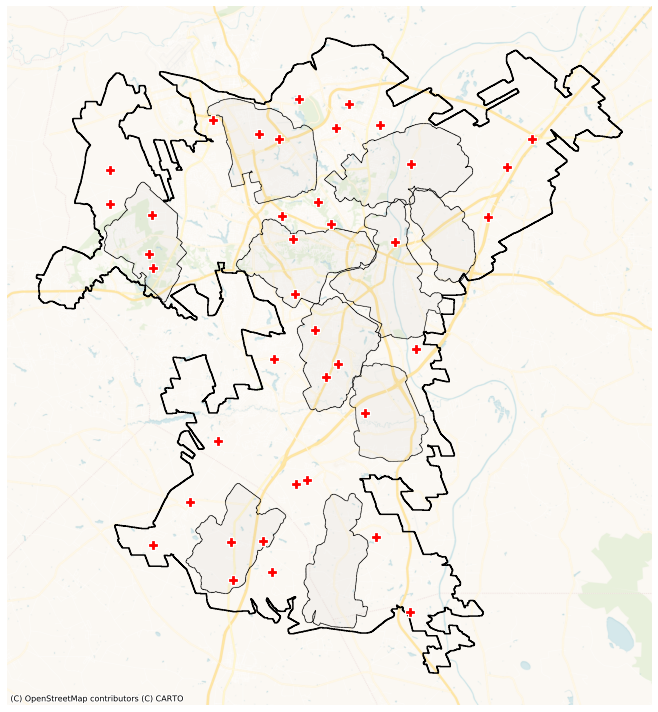

In [7]:
# Set up fig
fig, ax = plt.subplots(figsize=(10, 10))

# Plot city outline
ax = city.query('Catchment_ID == "city_outline"').boundary.plot(edgecolor='black', ax=ax)

# Plot catchment outlines
# Transparent gray facecolor
ax = city.query('Catchment_ID != "city_outline"').boundary.plot(
    edgecolor=None, facecolor='gray', alpha=0.05,
    ax=ax)
# Black outline
ax = city.query('Catchment_ID != "city_outline"').boundary.plot(
    edgecolor='black', linewidth=0.5,
    ax=ax)

# Add basemap
ctx.add_basemap(ax, zoom=12, url=ctx.providers.CartoDB.VoyagerNoLabels)

# Add pharmacies
pharm.plot(
    ax=ax, marker='P', markersize=120,
    color='red', edgecolors='white', linewidths=1.25,
    zorder=20 # to force these to be on top
)

# # Label catchments
# city.query('Catchment_ID != "city_outline"').apply(
#     lambda x: ax.annotate(
#         s=get_catchment_id(x['Catchment_ID']), 
#         xy=x['geometry'].centroid.coords[0], 
#         ha=('center' if x['Catchment_ID'] != '08' else 'left'), # site 08 has a pharmacy where the number goes
#         va=('center' if x['Catchment_ID'] != '10' else 'top'), # site 10 has a pharmacy where the number goes
#         fontsize=20,
#         zorder=35 # arrange layer relative to pharmacies
#         ), 
#     axis=1);

ax.set_axis_off()

fig.tight_layout()
fig.savefig('../plots/map1.sampling-locations-pharmacies.png', dpi=300, bbox_inches='tight')
fig.savefig('../plots/map1.sampling-locations-pharmacies.pdf', dpi=300, bbox_inches='tight')

# Maps 2 and 3: relative MME and detection rates

Maps 2 and 3 visualize the data from the pilot study. Map 2 shows the relative average MME for each prescription opioid in each sampling area. Map 3 shows the detection rate of each opioid over the sampling period.

## Data pre-processing for Maps 2 and 3

In [8]:
## Get mean over all samples

# Track number of samples
n_samples = data.groupby(['Catchment_ID', 'Parent_drug']).size().reset_index(name='n_samples')

# Average MME rate and detection over all reports
data = data.groupby(['Catchment_ID', 'Parent_drug']).mean().reset_index()

# Merge them
data = pd.merge(data, n_samples)

In [9]:
# Add geometry as a column to the dataframe
df = pd.merge(
    data, city, 
    left_on='Catchment_ID', right_on='Catchment_ID', 
    how='left')

# Convert back to geodataframe
df = gpd.GeoDataFrame(df)
#df.head()

In [10]:
# Order drugs based on average detection
drug_order = df.groupby(['Parent_drug']).mean().sort_values(by='detected', ascending=False).index

In [11]:
# Define some common columns
mme_col = 'MME_rate(MME/day/1000people)'
rate_col = 'detected'
binned_rate = 'binned_rate'

## Data pre-processing for Map 2

In [12]:
# Get total MME per catchment to normalize
total_mme = data.groupby(['Catchment_ID']).sum()[mme_col]
total_mme = total_mme.reset_index(name='total_mme')

# Combine back with the original df
piedf = pd.merge(df, total_mme) 
piedf.head()

,Catchment_ID,Parent_drug,MME_rate(MME/day/1000people),detected,n_samples,geometry,total_mme
0,Site_01,Codeine,0.485352,1.000000,6,"POLYGON ((-8798938.724 4177032.058, -8798929.3...",36.392902
1,Site_01,Hydrocodone,21.619679,0.833333,6,"POLYGON ((-8798938.724 4177032.058, -8798929.3...",36.392902
2,Site_01,Hydromorphone,0.003431,0.166667,6,"POLYGON ((-8798938.724 4177032.058, -8798929.3...",36.392902
3,Site_01,Morphine,3.178498,0.166667,6,"POLYGON ((-8798938.724 4177032.058, -8798929.3...",36.392902
4,Site_01,Oxycodone,9.798074,0.666667,6,"POLYGON ((-8798938.724 4177032.058, -8798929.3...",36.392902


In [13]:
## Get ratios of each parent drug

# Calculate relative MME for each drug in each site
piedf['mme_proportion'] = piedf[mme_col] / piedf['total_mme']

# Extract the per-catchment ratios into a dict with lists
ratio_dict = {}
drugs_dict = {}
for c, subdf in piedf.groupby('Catchment_ID'):
    # Get the ratio of each drug for that catchment
    ratio_dict[c] = subdf.sort_values(by='Parent_drug')['mme_proportion'].values
    
    # Just to be sure that they're in the same order in all catchments, get the drugs too
    drugs_dict[c] = subdf.sort_values(by='Parent_drug')['Parent_drug'].values

In [14]:
# Manually check that the drugs are in the same order in all catchments
# This is the order of the ratios, so it's important that they're the same
#drugs_dict

## Plot Map 2

In [15]:
def draw_pie(ax, ratios=[0.1, 0.5, 0.4], X=0, Y=0, size=1000, colors=['r', 'b', 'g']):
    """
    Copied from 
    https://www.geophysique.be/2010/11/15/matplotlib-basemap-tutorial-05-adding-some-pie-charts/
    
    Adjusting wedge size to prevent exploding wedges from here: 
    https://stackoverflow.com/questions/51409257/
       exploding-wedges-of-pie-chart-when-plotting-them-on-a-map-python-matplotlib
    
    Manually draw pie chart from scratch.
    
    Parameters
    ----------
    ax : matplotlib axes object
    ratios : list, array-like
        proportion for each element. Should sum to 1 (the code does not check this)
    X, Y : int
        x, y locations for pie chart
    size : int
        relative size of pies
    colors : list
        list of colors for each element. length should be >= len(ratios)
    
    """
    N = len(ratios)

    xy = []
    s = []

    start = 0.
    for ratio in ratios:
        x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        xy1 = np.column_stack([x, y])
        xy.append(xy1)
        
        # Also track the size of the wedge, 
        # https://stackoverflow.com/questions/51409257/
        #    exploding-wedges-of-pie-chart-when-plotting-them-on-a-map-python-matplotlib
        s1 = np.abs(xy1).max()
        s.append(s1)
        
        start += ratio

    for xyi, si, ci in zip(xy, s, colors):
        # Also edited here, changed marker=(xyi, 0) to marker=xyi to avoid deprecation warning
        # zorder as a high number forces the pie charts to be on top
        ax.scatter([X],[Y] , marker=xyi, s=size*si**2, facecolor=ci , zorder=1000, 
                   edgecolor='black', linewidth=0.25)


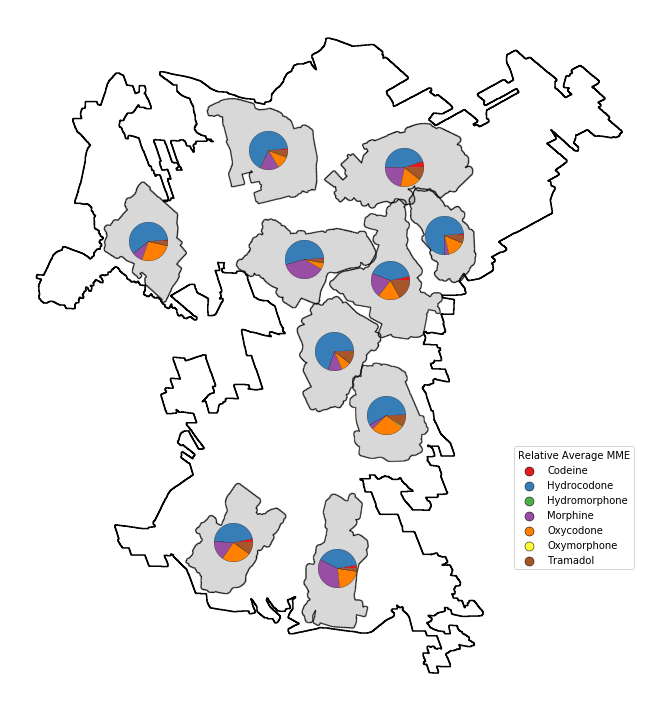

In [16]:
# Get colors for each prescription drug
prescription_drugs = drugs_dict['Site_01'] # This returns the list of drugs, in the order of plotting
prescription_colors = sns.color_palette('Set1', n_colors=len(prescription_drugs))

# Get the geometries for each catchment into a dictionary
geomdf = piedf[['Catchment_ID', 'geometry']].drop_duplicates()
geomdict = dict(zip(geomdf['Catchment_ID'], geomdf['geometry']))

# Set up fig
fig, ax = plt.subplots(figsize=(10, 10))

# Plot city outline
ax = city.query('Catchment_ID == "city_outline"').boundary.plot(edgecolor='black', ax=ax)

# Plot catchment outlines
# Transparent gray facecolor
ax = city.query('Catchment_ID != "city_outline"').boundary.plot(
    edgecolor=None, facecolor='gray', alpha=0.3,
    ax=ax)
# Black outline
ax = city.query('Catchment_ID != "city_outline"').boundary.plot(
    edgecolor='black', linewidth=0.5,
    ax=ax)

# Plot pie charts
for catchment, ratios in ratio_dict.items():
    
    # Get catchment geometry from the dictionary
    geom = geomdict[catchment]
    x = geom.centroid.coords[0][0]
    y = geom.centroid.coords[0][1]
    
    draw_pie(ax, ratios=ratios, X=x, Y=y, colors=prescription_colors, size=1500)

ax.set_axis_off()

## LEGEND
# Make new plot for fake data
figleg, axleg = plt.subplots()

# Iterate through each drug and its color
for d, c in zip(prescription_drugs, prescription_colors):
    # Plot and label each color/drug combo with fake data
    axleg.scatter(
        [0, 0], [1, 1], 
        edgecolor='k', linewidth=0.5, 
        color=c, label=d)

# Add legend to the fake plot
axleg.legend()

# Get legend handles from that
handles, labels = axleg.get_legend_handles_labels()

# Add legend to our pie chart figure
fig.legend(handles, labels, loc=(0.78, 0.2), 
           scatterpoints=1, markerscale=1.5, 
           title='Relative Average MME')

# Close the unnecessary legend plot
plt.close(fig=figleg)

fig.tight_layout()

fig.savefig('../plots/map2.pie_charts_no_background.png', dpi=300, transparent=True)


# Map 3: relative detection rate for each opioid

## Pre-processing

In [17]:
# Convert detection rate to 5 bins
df['binned_rate'] = pd.cut(df[rate_col], bins=5)

# Make palette with bin: color
palette = dict(zip(
    df['binned_rate'].sort_values().unique(), 
    sns.color_palette('Purples', n_colors=5)
))

In [18]:
# Print the palette keys so I can make my manual labels
#print(palette.keys())

In [19]:
# Make bin labels
bin_labels = {
    pd.Interval(-0.001, 0.2, closed='right'):  '0-20%',
    pd.Interval(0.2, 0.4, closed='right'): '21-40%',
    pd.Interval(0.4, 0.6, closed='right'): '41-60%',
    pd.Interval(0.6, 0.8, closed='right'): '61-80%',
    pd.Interval(0.8, 1.0, closed='right'): '81-100%'
}

## Plot Map 3

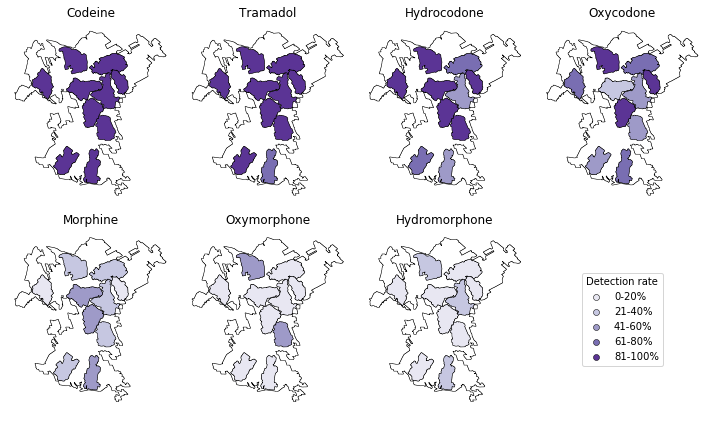

In [20]:
fig, AX = plt.subplots(2, 4, figsize=(10, 6))

AX = AX.flatten()

i = 0
for d in drug_order:
    # Get that drug's data
    subdf = df.query('Parent_drug == @d')
    
    # Sort by bin
    subdf = subdf.sort_values(by=binned_rate)

    ax = AX[i]
    
    # Plot outline
    (city.query('Catchment_ID == "city_outline"')
         .boundary.plot(edgecolor='black', ax=ax, linewidth=0.5)
    )

    # Make cmap with only the colors present in this data
    cmap = ListedColormap(
        [color for bin_name, color in palette.items()
         if bin_name in subdf[binned_rate].unique()]
    )

    # Plot detection rate
    subdf.plot(
        column=binned_rate, 
        legend=False, 
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        ax=ax
    )
    
    ax.set_title(d, fontsize=12)
    ax.set_axis_off()
    
    i += 1

# In last axis, make just the legend
ax = AX[i]
for b in df[binned_rate].sort_values().unique():
    ax.scatter([], [], # empty data
               c=[palette[b]], label=bin_labels[b], # color and label I want
               edgecolor='k', linewidth=0.5)

# Turn on legend
ax.legend(loc='center', title='Detection rate')

# Remove axis
ax.set_axis_off()

fig.tight_layout()
fig.savefig('../plots/map3.heatmaps_horizontal.png', dpi=300, transparent=True)